<a href="https://colab.research.google.com/github/AntarikshVerma/AI_Agent_In_Langgraph/blob/main/Langgraph_agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
# !pip install tavily-python==0.3.3
# !pip install duckduckgo_search==5.3.1b1
# !pip install beautifulsoup4==4.12.3
# !pip install openai==1.30.1
# !pip install langgraph==0.0.53
# !pip install langchain_core==0.2.0
# !pip install langchain_openai==0.1.7
# !pip install langchain-community==0.2.0
# !pip install langchain==0.2.0
# !pip install aiosqlite==0.20.0
# !pip install pygments==2.17.2
# !pip install pygraphviz==1.13
# !pip install gradio==4.31.3
# !apt install libgraphviz-dev
# !pip install pygraphviz


In [28]:
import os
from google.colab import userdata
open_ai_key=userdata.get('OPENAI_API_KEY')
open_ai_base=userdata.get('OPEN_API_URL')
open_ai_base=userdata.get('OPEN_API_URL')
tavili_api_key=userdata.get('TAVILY_API_KEY')
api_version="2023-07-01-preview"

os.environ["OPENAI_API_VERSION"] = "2023-12-01-preview"
os.environ["AZURE_OPENAI_ENDPOINT"] = open_ai_base
os.environ["AZURE_OPENAI_API_KEY"] = open_ai_key
os.environ["TAVILY_API_KEY"]=tavili_api_key

In [39]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_openai import AzureOpenAI

In [45]:
# llm_gpt_4 = AzureOpenAI(
#     deployment_name="gpt-4",
# )

llm_gpt_4 = ChatOpenAI(openai_api_key=open_ai_key,temperature=0.5)
print(llm_gpt_4)


client=<openai.resources.chat.completions.Completions object at 0x783b63de3760> async_client=<openai.resources.chat.completions.AsyncCompletions object at 0x783b40e134f0> temperature=0.5 openai_api_key=SecretStr('**********') openai_proxy=''


In [31]:
tool = TavilySearchResults(max_results=4) #increased number of results
print(type(tool))
print(tool.name)

<class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'>
tavily_search_results_json


In [32]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

In [41]:
class Agent:

    def __init__(self, model, tools, system=""):
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_openai)
        graph.add_node("action", self.take_action)
        graph.add_conditional_edges(
            "llm",
            self.exists_action,
            {True: "action", False: END}
        )
        graph.add_edge("action", "llm")
        graph.set_entry_point("llm")
        self.graph = graph.compile()
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)

    def exists_action(self, state: AgentState):
        result = state['messages'][-1]
        return len(result.tool_calls) > 0

    def call_openai(self, state: AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {'messages': [message]}

    def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            if not t['name'] in self.tools:      # check for bad tool name from LLM
                print("\n ....bad tool name....")
                result = "bad tool name, retry"  # instruct LLM to retry if bad
            else:
                result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Back to the model!")
        return {'messages': results}

In [46]:
prompt = """You are a smart research assistant. Use the search engine to look up information. \
You are allowed to make multiple calls (either together or in sequence). \
Only look up information when you are sure of what you want. \
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""

abot = Agent(llm_gpt_4, [tool], system=prompt)

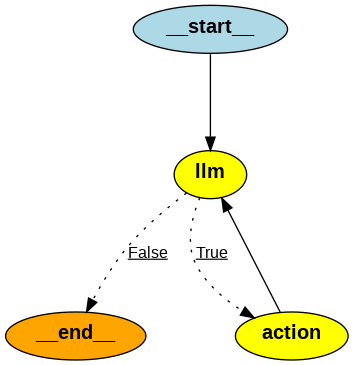

In [47]:
from IPython.display import Image

Image(abot.graph.get_graph().draw_png())